In [29]:
import siibra
from tqdm import tqdm

In [2]:
# authenticate with EBRAINS 
siibra.fetch_ebrains_token()

Your EBRAINS username: dicksche
Your EBRAINS password: ········


In [85]:
# fetch receptor features linked to cytoarchitectonic regions
jubrain = siibra.parcellations.JULICH_BRAIN_CYTOARCHITECTONIC_MAPS_2_9
receptor_features = siibra.get_features(jubrain, siibra.modalities.ReceptorDistribution)
print(f"{len(receptor_features)} features found.")

37 features found.


In [82]:
# fetch Desikan/Kiliany map in MNI space
dk = siibra.parcellations.DESIKAN_KILLIANY_2006
mni152 = siibra.spaces.MNI152_2009C_NONL_ASYM
dkmap = dk.get_map(mni152)

In [84]:
# find significant matches of the cytoarchitectonic regions 
# to which receptor features have been assigned to regions 
# in the DK atlas.
# For each significant match, store the URL of the Receptor dataset
# together with the region association.
condition = 'correlation > 0.3 or contained > 0.8 or contains > 0.8'

features_mapped = {}
for f in tqdm(
    receptor_features, total=len(receptor_features), unit='features'
):
    url = f"https://search.kg.ebrains.eu/instances/Dataset/{f.id.split('/')[-1]}"
    features_mapped[url] = []
    for juregion in f.matched_region:
        pmap = juregion.get_regional_map(mni152, "continuous")
        if pmap is not None:
            assigned = pd.DataFrame([
                {'JuRegion': juregion, 'DkRegion': dkregion} | scores
                for dkregion, _ , scores in dkmap.assign(pmap.fetch())
            ])
            for match in assigned.query(condition).itertuples():
                features_mapped[url].append(match._asdict())
                features_mapped[url][-1].pop('Index')
            

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:39<00:00,  1.08s/features]


/Users/tdickscheid/src/siibra-python/venv/lib/python3.9/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),
/Users/tdickscheid/src/siibra-python/venv/lib/python3.9/site-packages/nilearn/plotting/displays/_slicers.py:145: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure = plt.figure(figure, figsize=figsize,


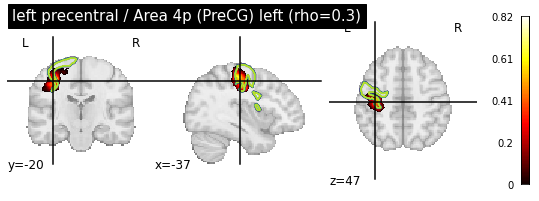

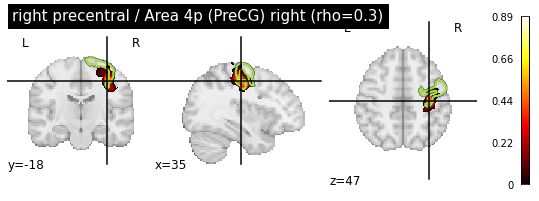

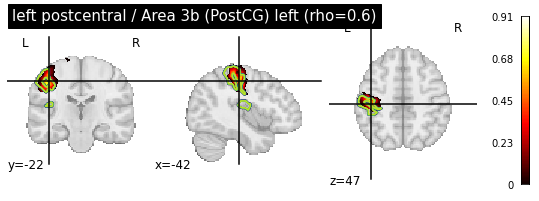

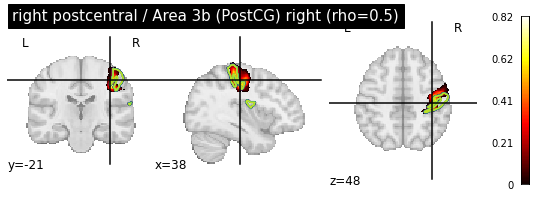

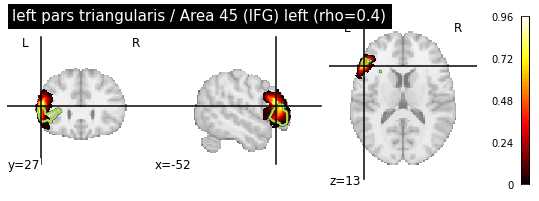

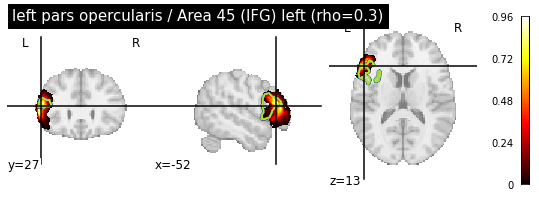

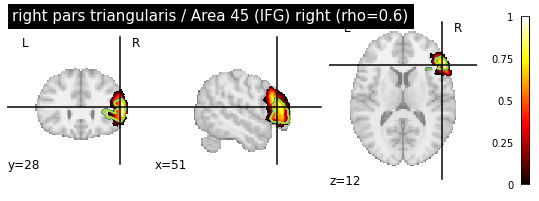

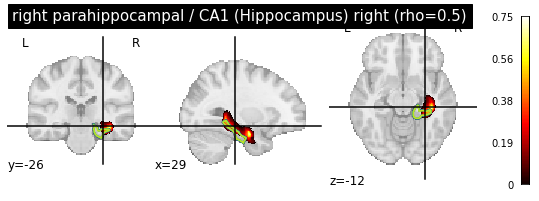

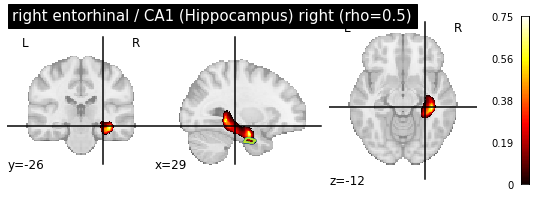

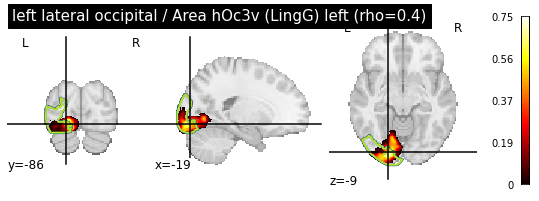

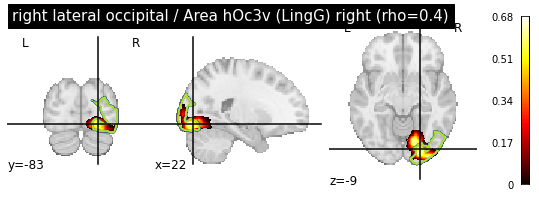

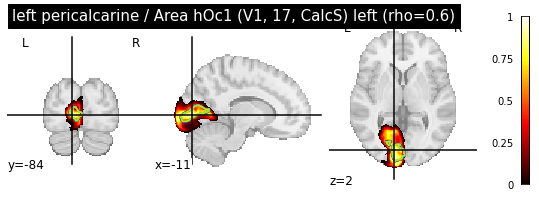

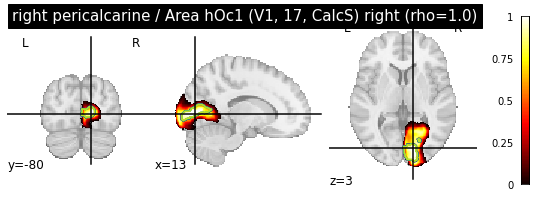

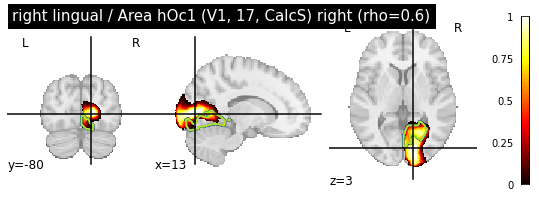

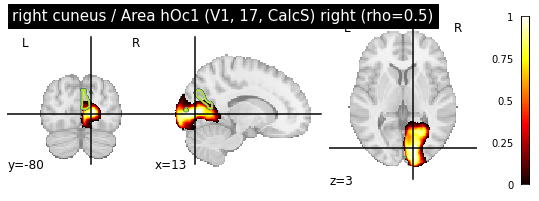

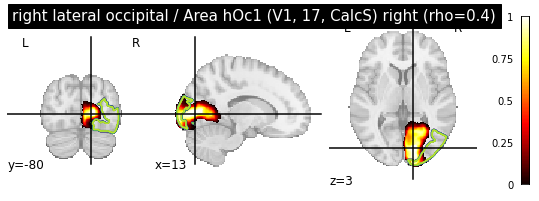

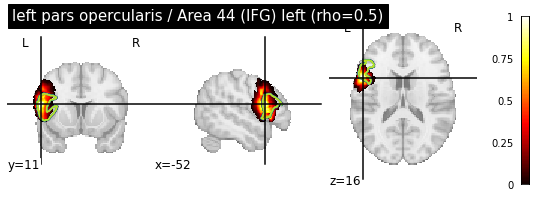

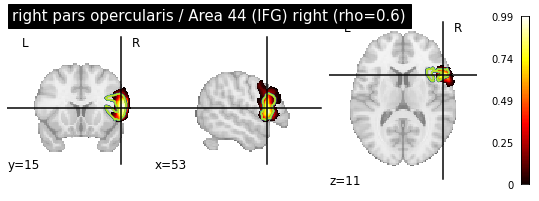

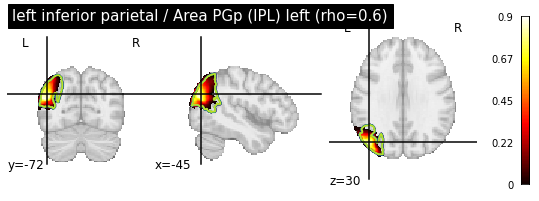

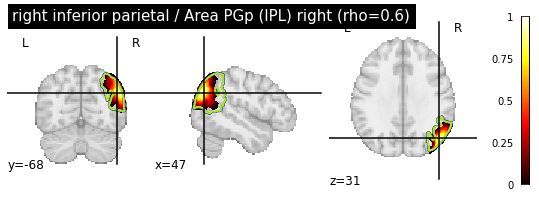

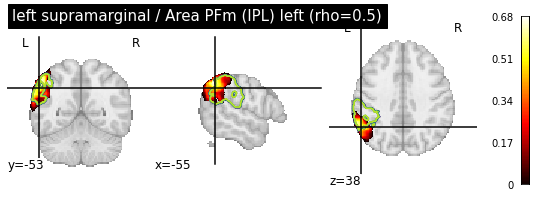

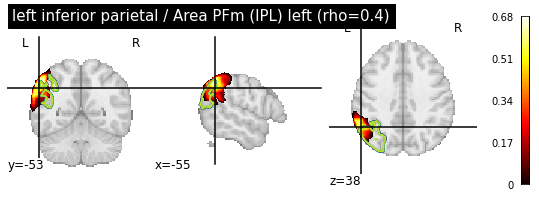

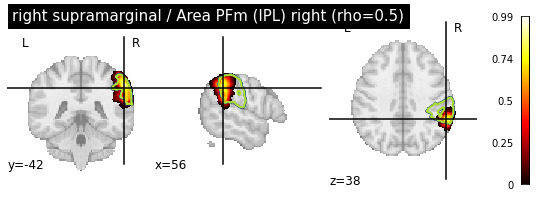

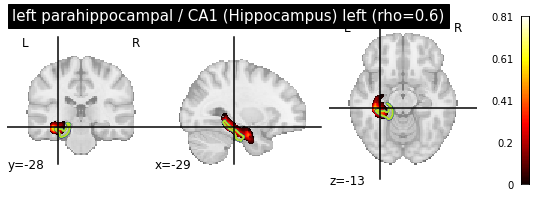

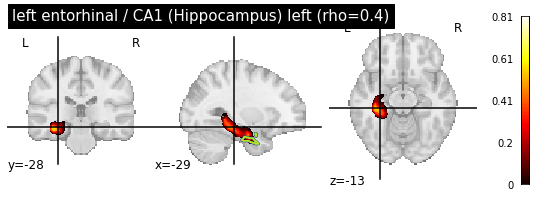

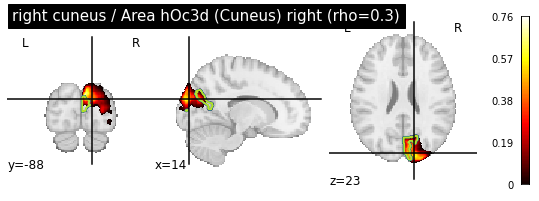

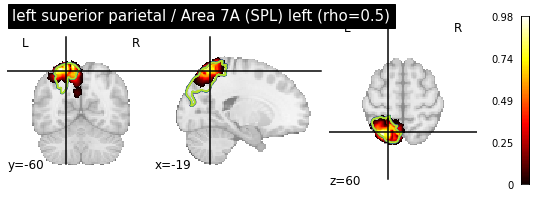

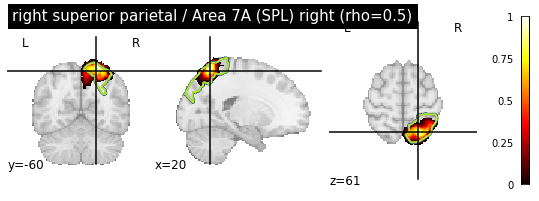

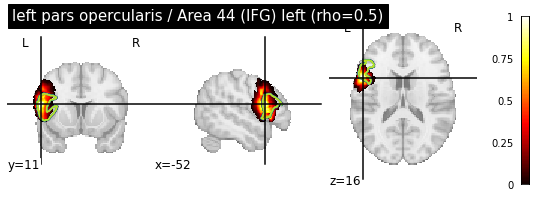

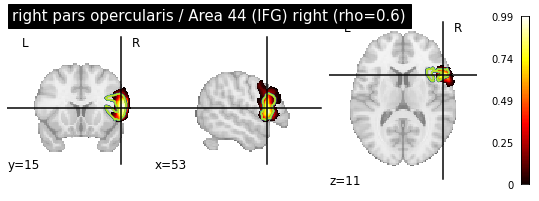

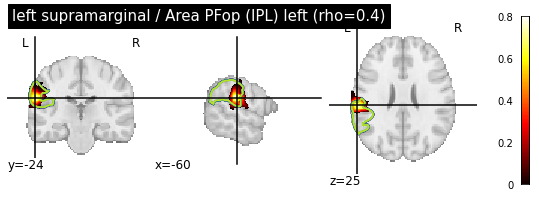

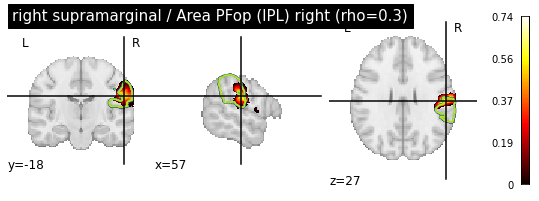

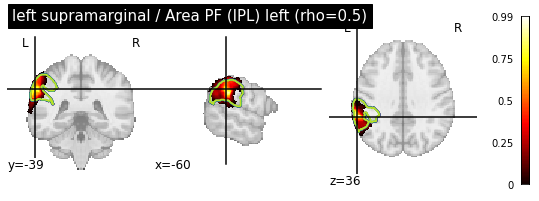

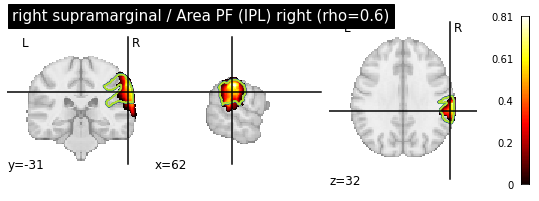

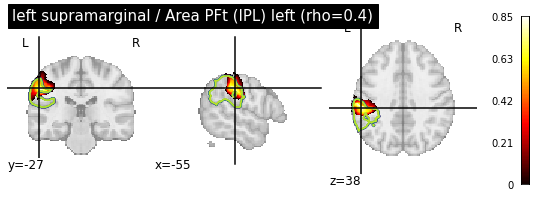

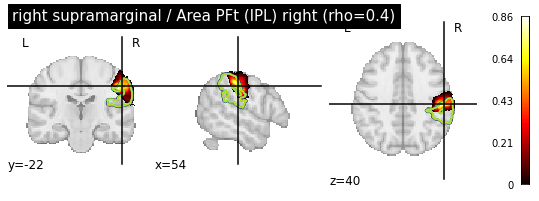

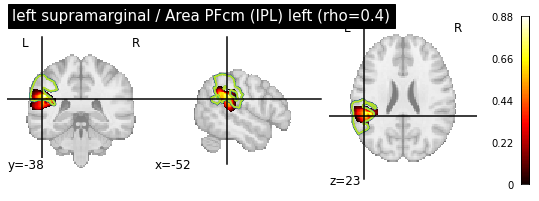

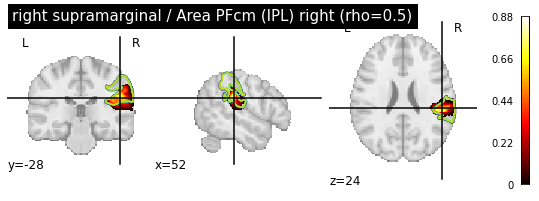

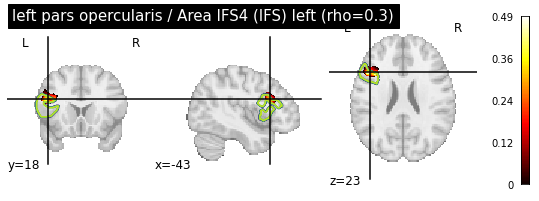

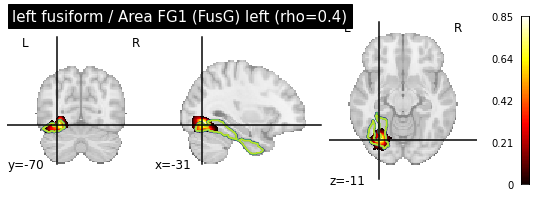

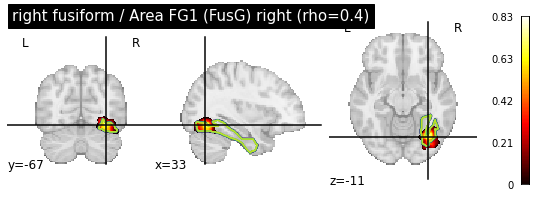

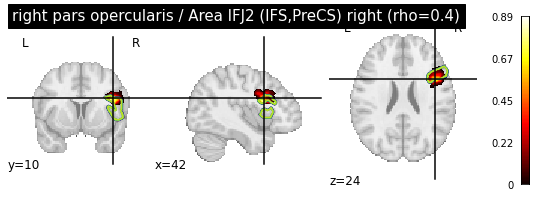

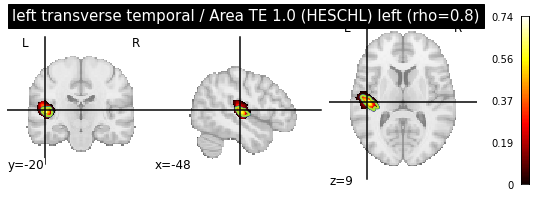

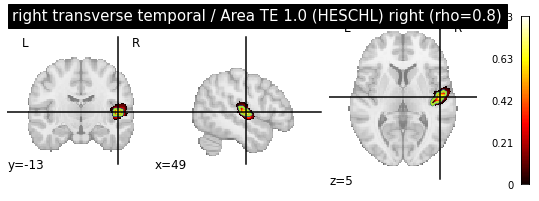

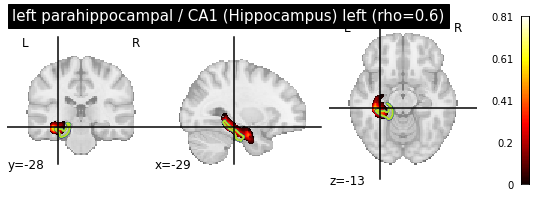

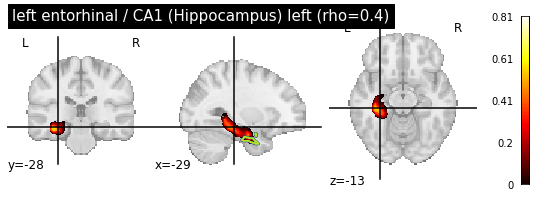

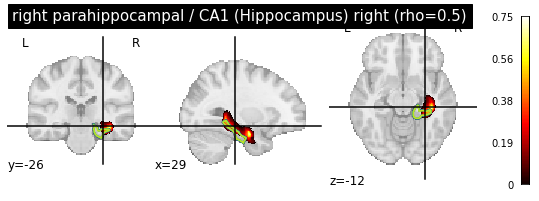

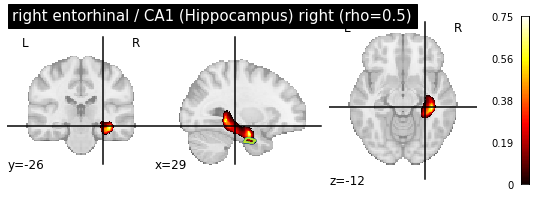

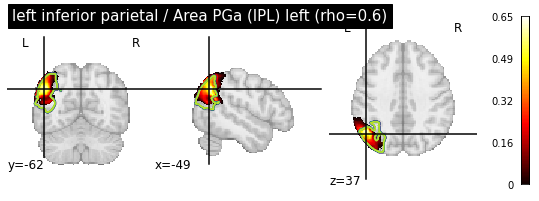

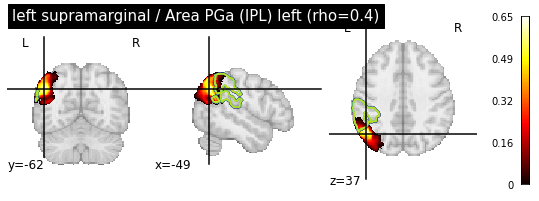

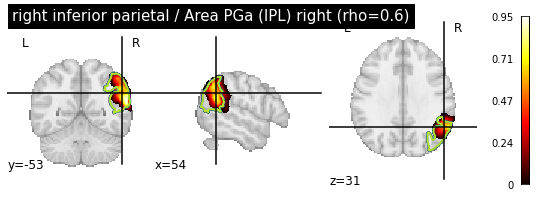

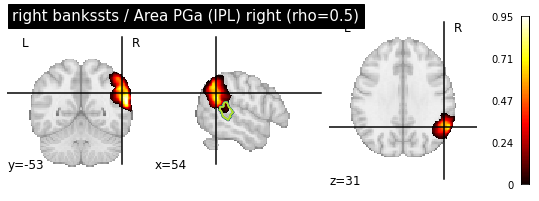

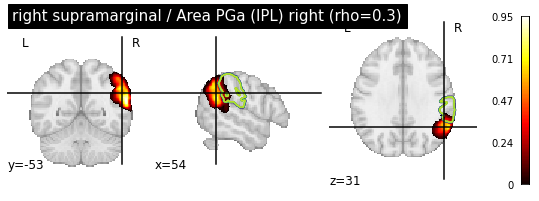

In [102]:
# plot the assignments
from nilearn import plotting
for feature_url, assignments in features_mapped.items():
    for assignment in assignments:
        dkmask = dkmap.fetch_regionmap(assignment['DkRegion'])
        pmap = assignment['JuRegion'].get_regional_map(mni152, "continuous")
        view = plotting.plot_stat_map(
            pmap.fetch(), 
            title=f"{assignment['DkRegion'].name} / {assignment['JuRegion'].name} (rho={assignment['correlation']:.1f})"
        )
        view.add_contours(dkmask)

In [113]:
# create tabular output
out = pd.DataFrame(
    [
        (url, m['JuRegion'].name, m['DkRegion'], m['correlation'], m['overlap'], m['contained'], m['contains'], ) 
        for url, matches in features_mapped.items() for m in matches
    ], 
    columns=['dataset', 'Julich-Brain region', 'DK region', 'correlation', 'overlap', 'containedness (J>DK)', 'containedness (DK>J)']
)
out.to_excel('receptor_datasets_mapped_to_dk.xlsx')